le taux de compression est de l'ordre de 84.93734335839599


Quel est la fréquence de coupure? 6


Taux d'erreur total sur l'image en couleur : 0.04631735881051515


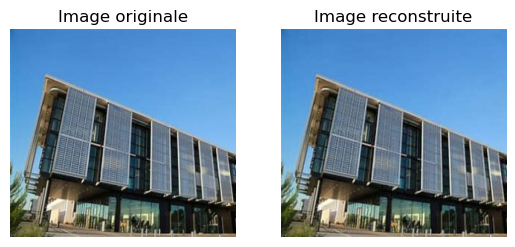

Temps d'exécution : 2.812161445617676 secondes


In [9]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Dec 18 13:18:50 2023

"""
#importation des bibliothèques

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time 

debut = time.time()
#A/INITIALISATION


#lecture de l'image

M=mpimg.imread("C:/Users/radou/Desktop/new folder/Test2.png")

if M.shape[2] == 4:  # Vérifie si l'image a quatre canaux (avec canal alpha)
    M = M[:, :, :3]

#Transformation en matrice 2D

H=M[:,:,1]
K=M[:,:,2]
L=M[:,:,0]



#tronquer l'image

lignes, colonnes = L.shape

l= (lignes // 8) * 8   #tronque en multiple de 8
c = (colonnes // 8) * 8

M = M[:l, :c] #pour faire le taux d'erreur plus tard
L = L[:l, :c]
H = H[:l, :c]
K = K[:l, :c]

#Transformations des intensités

L=(L*255)-128  #rammene les valeurs entre -128 et 127
H=(H*255)-128
K=(K*255)-128




# Calcul de P

P = np.zeros((8, 8))
c0 = 1 / np.sqrt(2)

# Première ligne de P
P[0, :] = 0.5 * c0

# Calcul du reste de P
for i in range(1, 8):
    for j in range(8):
        P[i, j] = 0.5 * np.cos(((2 * j + 1) * i * np.pi) / 16)


#B/COMPRESSION

Q=np.array([[16, 11, 10, 16, 24, 40, 51, 61],
   [12, 12, 13, 19, 26, 58, 60, 55],
   [14, 13, 16, 24, 40, 57, 69, 56],
   [14, 17, 22, 29, 51, 87, 80, 62],
   [18, 22, 37, 56, 68, 109, 103, 77],
   [24, 35, 55, 64, 81, 104, 113, 92],
   [49, 64, 78, 87, 103, 121, 120, 101],
   [72, 92, 95, 98, 112, 100, 103, 99]])


#Compression

MC=np.zeros((l,c))
HC=np.zeros((l,c))
KC=np.zeros((l,c))

for i in range(l//8):
    for j in range(c//8):
        D = np.dot(np.dot(P,L[8*i:8*(1+i),8*j:8*(1+j)]),np.transpose(P))
        D = np.round(D / Q).astype(int)
        E = np.dot(np.dot(P,H[8*i:8*(1+i),8*j:8*(1+j)]),np.transpose(P))
        E = np.round(E / Q).astype(int)
        F = np.dot(np.dot(P,K[8*i:8*(1+i),8*j:8*(1+j)]),np.transpose(P))
        F = np.round(F / Q).astype(int)
        MC[8*i:8*(1+i),8*j:8*(1+j)] = np.clip(D, -128, 127)
        HC[8*i:8*(1+i),8*j:8*(1+j)] = np.clip(E, -128, 127)
        KC[8*i:8*(1+i),8*j:8*(1+j)] = np.clip(F, -128, 127)

MN=np.stack((MC,HC,KC), axis=-1)

#Taux de compression

s=np.sum(MN==0)
taux_compression=(s/(3*l*c))*100
print('le taux de compression est de l\'ordre de',taux_compression)



#Filtrage des haute fréquences et debruitage

f = int(input('Quel est la fréquence de coupure?'))# le temps que vous prenez pour entrer cette frequence s'ajoute au temps total d'execution 




for i in range(l // 8):
    for j in range(c // 8):
        sous_matrice1 = MC[8*i:8*(i+1),8*j:8*(j+1)]  # Extraire la sous-matrice 8x8
        indices1 = np.indices(sous_matrice1.shape).sum(axis=0) 
        sous_matrice1[indices1 > f] = 0
        MC[8*i:8*(i+1), 8*j:8*(j+1)] = sous_matrice1
        sous_matrice2 = HC[8*i:8*(i+1),8*j:8*(j+1)]  # Extraire la sous-matrice 8x8
        indices2 = np.indices(sous_matrice2.shape).sum(axis=0) 
        sous_matrice2[indices2 > f] = 0
        HC[8*i:8*(i+1), 8*j:8*(j+1)] = sous_matrice2
        sous_matrice3 = KC[8*i:8*(i+1),8*j:8*(j+1)]  # Extraire la sous-matrice 8x8
        indices3 = np.indices(sous_matrice3.shape).sum(axis=0)
        sous_matrice3[indices3 > f] = 0
        KC[8*i:8*(i+1), 8*j:8*(j+1)] = sous_matrice3



#C/DECOMPRESSION



for i in range(l//8):
    for j in range(c//8):
        MC[8*i:8*(1+i),8*j:8*(1+j)] = np.round(MC[8*i:8*(1+i),8*j:8*(1+j)]*Q).astype(int)
        MC[8*i:8*(1+i),8*j:8*(1+j)] = np.dot(np.dot(np.transpose(P),MC[8*i:8*(1+i),8*j:8*(1+j)]),P)
        MC[8*i:8*(1+i),8*j:8*(1+j)] = np.clip(MC[8*i:8*(1+i),8*j:8*(1+j)], -128, 127)
        HC[8*i:8*(1+i),8*j:8*(1+j)] = np.round(HC[8*i:8*(1+i),8*j:8*(1+j)]*Q).astype(int)
        HC[8*i:8*(1+i),8*j:8*(1+j)] = np.dot(np.dot(np.transpose(P),HC[8*i:8*(1+i),8*j:8*(1+j)]),P)
        HC[8*i:8*(1+i),8*j:8*(1+j)] = np.clip(HC[8*i:8*(1+i),8*j:8*(1+j)], -128, 127)
        KC[8*i:8*(1+i),8*j:8*(1+j)] = np.round(KC[8*i:8*(1+i),8*j:8*(1+j)]*Q).astype(int)
        KC[8*i:8*(1+i),8*j:8*(1+j)] = np.dot(np.dot(np.transpose(P),KC[8*i:8*(1+i),8*j:8*(1+j)]),P)
        KC[8*i:8*(1+i),8*j:8*(1+j)] = np.clip(KC[8*i:8*(1+i),8*j:8*(1+j)], -128, 127)

MC=(MC+128)/255
HC=(HC+128)/255
KC=(KC+128)/255

MNf=np.stack((MC,HC,KC), axis=-1)

#Calcul du taux d'erreur

erreur_totale = np.linalg.norm(M - MNf) / np.linalg.norm(M)

print("Taux d'erreur total sur l'image en couleur :", erreur_totale)

#D/AFFICHER LA NOUVELLE IMAGE



plt.subplot(1, 2, 1)
plt.title('Image originale')
plt.imshow(M)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Image reconstruite')
plt.imshow(MNf)
plt.axis('off')
plt.show()
fin = time.time()
temps_execution = fin - debut
print(f"Temps d'exécution : {temps_execution} secondes")

le taux de compression est de l'ordre de 84.93734335839599
Taux d'erreur total sur l'image en couleur : 0.040580159642963624


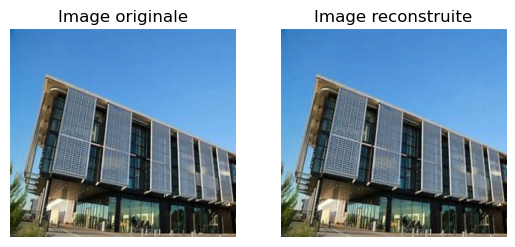

Temps d'exécution : 1.095094919204712 secondes


In [10]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Dec 18 13:18:50 2023

sans filtrage 
"""
#importation des bibliothèques

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time 

debut = time.time()
#A/INITIALISATION


#lecture de l'image

M=mpimg.imread("C:/Users/radou/Desktop/New folder/Test2.png")

if M.shape[2] == 4:  # Vérifie si l'image a quatre canaux (avec canal alpha)
    M = M[:, :, :3]

#Transformation en matrice 2D

H=M[:,:,1]
K=M[:,:,2]
L=M[:,:,0]



#tronquer l'image

lignes, colonnes = L.shape

l= (lignes // 8) * 8   #tronque en multiple de 8
c = (colonnes // 8) * 8

M = M[:l, :c] #pour faire le taux d'erreur plus tard
L = L[:l, :c]
H = H[:l, :c]
K = K[:l, :c]

#Transformations des intensités

L=(L*255)-128  #rammene les valeurs entre -128 et 127
H=(H*255)-128
K=(K*255)-128




# Calcul de P

P = np.zeros((8, 8))
c0 = 1 / np.sqrt(2)

# Première ligne de P
P[0, :] = 0.5 * c0

# Calcul du reste de P
for i in range(1, 8):
    for j in range(8):
        P[i, j] = 0.5 * np.cos(((2 * j + 1) * i * np.pi) / 16)


#B/COMPRESSION

Q=np.array([[16, 11, 10, 16, 24, 40, 51, 61],
   [12, 12, 13, 19, 26, 58, 60, 55],
   [14, 13, 16, 24, 40, 57, 69, 56],
   [14, 17, 22, 29, 51, 87, 80, 62],
   [18, 22, 37, 56, 68, 109, 103, 77],
   [24, 35, 55, 64, 81, 104, 113, 92],
   [49, 64, 78, 87, 103, 121, 120, 101],
   [72, 92, 95, 98, 112, 100, 103, 99]])


#Compression

MC=np.zeros((l,c))
HC=np.zeros((l,c))
KC=np.zeros((l,c))

for i in range(l//8):
    for j in range(c//8):
        D = np.dot(np.dot(P,L[8*i:8*(1+i),8*j:8*(1+j)]),np.transpose(P))
        D = np.round(D / Q).astype(int)
        E = np.dot(np.dot(P,H[8*i:8*(1+i),8*j:8*(1+j)]),np.transpose(P))
        E = np.round(E / Q).astype(int)
        F = np.dot(np.dot(P,K[8*i:8*(1+i),8*j:8*(1+j)]),np.transpose(P))
        F = np.round(F / Q).astype(int)
        MC[8*i:8*(1+i),8*j:8*(1+j)] = np.clip(D, -128, 127)
        HC[8*i:8*(1+i),8*j:8*(1+j)] = np.clip(E, -128, 127)
        KC[8*i:8*(1+i),8*j:8*(1+j)] = np.clip(F, -128, 127)


MN=np.stack((MC,HC,KC), axis=-1)

#Taux de compression

s=np.sum(MN==0)
taux_compression=(s/(3*l*c))*100
print('le taux de compression est de l\'ordre de',taux_compression)



#C/DECOMPRESSION



for i in range(l//8):
    for j in range(c//8):
        MC[8*i:8*(1+i),8*j:8*(1+j)] = np.round(MC[8*i:8*(1+i),8*j:8*(1+j)]*Q).astype(int)
        MC[8*i:8*(1+i),8*j:8*(1+j)] = np.dot(np.dot(np.transpose(P),MC[8*i:8*(1+i),8*j:8*(1+j)]),P)
        MC[8*i:8*(1+i),8*j:8*(1+j)] = np.clip(MC[8*i:8*(1+i),8*j:8*(1+j)], -128, 127)
        HC[8*i:8*(1+i),8*j:8*(1+j)] = np.round(HC[8*i:8*(1+i),8*j:8*(1+j)]*Q).astype(int)
        HC[8*i:8*(1+i),8*j:8*(1+j)] = np.dot(np.dot(np.transpose(P),HC[8*i:8*(1+i),8*j:8*(1+j)]),P)
        HC[8*i:8*(1+i),8*j:8*(1+j)] = np.clip(HC[8*i:8*(1+i),8*j:8*(1+j)], -128, 127)
        KC[8*i:8*(1+i),8*j:8*(1+j)] = np.round(KC[8*i:8*(1+i),8*j:8*(1+j)]*Q).astype(int)
        KC[8*i:8*(1+i),8*j:8*(1+j)] = np.dot(np.dot(np.transpose(P),KC[8*i:8*(1+i),8*j:8*(1+j)]),P)
        KC[8*i:8*(1+i),8*j:8*(1+j)] = np.clip(KC[8*i:8*(1+i),8*j:8*(1+j)], -128, 127)


MC=(MC+128)/255
HC=(HC+128)/255
KC=(KC+128)/255



MNf=np.stack((MC,HC,KC), axis=-1)

#Calcul du taux d'erreur

erreur_totale = np.linalg.norm(M - MNf) / np.linalg.norm(M)

print("Taux d'erreur total sur l'image en couleur :", erreur_totale)

#D/AFFICHER LA NOUVELLE IMAGE



plt.subplot(1, 2, 1)
plt.title('Image originale')
plt.imshow(M)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Image reconstruite')
plt.imshow(MNf)
plt.axis('off')
plt.show()
fin = time.time()
temps_execution = fin - debut
print(f"Temps d'exécution : {temps_execution} secondes")

le taux de compression est de l'ordre de 56.26879699248121
Taux d'erreur total sur l'image en couleur : 0.34838343


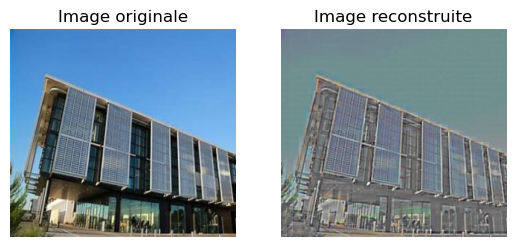

Temps d'exécution : 1.1858551502227783 secondes


In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Dec 18 13:18:50 2023

sans filtrage et sans multiplication par Q
"""
#importation des bibliothèques

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time 

debut = time.time()

#A/INITIALISATION


#lecture de l'image

M=mpimg.imread("C:/Users/radou/Desktop/New folder/Test2.png")

if M.shape[2] == 4:  # Vérifie si l'image a quatre canaux (avec canal alpha)
    M = M[:, :, :3]

#Transformation en matrice 2D

H=M[:,:,1]
K=M[:,:,2]
L=M[:,:,0]



#tronquer l'image

lignes, colonnes = L.shape

l= (lignes // 8) * 8   #tronque en multiple de 8
c = (colonnes // 8) * 8

M = M[:l, :c] #pour faire le taux d'erreur plus tard
L = L[:l, :c]
H = H[:l, :c]
K = K[:l, :c]

#Transformations des intensités

L=(L*255)-128  #rammene les valeurs entre -128 et 127
H=(H*255)-128
K=(K*255)-128




# Calcul de P

P = np.zeros((8, 8))
c0 = 1 / np.sqrt(2)

# Première ligne de P
P[0, :] = 0.5 * c0

# Calcul du reste de P
for i in range(1, 8):
    for j in range(8):
        P[i, j] = 0.5 * np.cos(((2 * j + 1) * i * np.pi) / 16)


#B/COMPRESSION

Q=np.array([[16, 11, 10, 16, 24, 40, 51, 61],
   [12, 12, 13, 19, 26, 58, 60, 55],
   [14, 13, 16, 24, 40, 57, 69, 56],
   [14, 17, 22, 29, 51, 87, 80, 62],
   [18, 22, 37, 56, 68, 109, 103, 77],
   [24, 35, 55, 64, 81, 104, 113, 92],
   [49, 64, 78, 87, 103, 121, 120, 101],
   [72, 92, 95, 98, 112, 100, 103, 99]])


#Compression
f = 6
for i in range(l//8):
    for j in range(c//8):
        D = np.dot(np.dot(P,L[8*i:8*(1+i),8*j:8*(1+j)]),np.transpose(P))
        E = np.dot(np.dot(P,H[8*i:8*(1+i),8*j:8*(1+j)]),np.transpose(P))
        F = np.dot(np.dot(P,K[8*i:8*(1+i),8*j:8*(1+j)]),np.transpose(P))
        L[8*i:8*(1+i),8*j:8*(1+j)] = np.clip(D, -128, 127)
        H[8*i:8*(1+i),8*j:8*(1+j)] = np.clip(E, -128, 127)
        K[8*i:8*(1+i),8*j:8*(1+j)] = np.clip(F, -128, 127)

for i in range(l // 8):
    for j in range(c // 8):
        sous_matrice1 = L[8*i:8*(i+1),8*j:8*(j+1)]  # Extraire la sous-matrice 8x8
        indices1 = np.indices(sous_matrice1.shape).sum(axis=0) 
        sous_matrice1[indices1 > f] = 0
        L[8*i:8*(i+1), 8*j:8*(j+1)] = sous_matrice1
        sous_matrice2 = H[8*i:8*(i+1),8*j:8*(j+1)]  # Extraire la sous-matrice 8x8
        indices2 = np.indices(sous_matrice2.shape).sum(axis=0) 
        sous_matrice2[indices2 > f] = 0
        H[8*i:8*(i+1), 8*j:8*(j+1)] = sous_matrice2
        sous_matrice3 = K[8*i:8*(i+1),8*j:8*(j+1)]  # Extraire la sous-matrice 8x8
        indices3 = np.indices(sous_matrice3.shape).sum(axis=0)
        sous_matrice3[indices3 > f] = 0
        K[8*i:8*(i+1), 8*j:8*(j+1)] = sous_matrice3


MN=np.stack((L,H,K), axis=-1)

#Taux de compression

s=np.sum(MN==0)
taux_compression=(s/(3*l*c))*100
print('le taux de compression est de l\'ordre de',taux_compression)


#C/DECOMPRESSION



for i in range(l//8):
    for j in range(c//8):
        """L[8*i:8*(1+i),8*j:8*(1+j)] = np.round(L[8*i:8*(1+i),8*j:8*(1+j)]*Q).astype(int)"""
        L[8*i:8*(1+i),8*j:8*(1+j)] = np.dot(np.dot(np.transpose(P),L[8*i:8*(1+i),8*j:8*(1+j)]),P)
        L[8*i:8*(1+i),8*j:8*(1+j)] = np.clip(L[8*i:8*(1+i),8*j:8*(1+j)], -128, 127)
        """H[8*i:8*(1+i),8*j:8*(1+j)] = np.round(H[8*i:8*(1+i),8*j:8*(1+j)]*Q).astype(int)"""
        H[8*i:8*(1+i),8*j:8*(1+j)] = np.dot(np.dot(np.transpose(P),H[8*i:8*(1+i),8*j:8*(1+j)]),P)
        H[8*i:8*(1+i),8*j:8*(1+j)] = np.clip(H[8*i:8*(1+i),8*j:8*(1+j)], -128, 127)
        """K[8*i:8*(1+i),8*j:8*(1+j)] = np.round(K[8*i:8*(1+i),8*j:8*(1+j)]*Q).astype(int)"""
        K[8*i:8*(1+i),8*j:8*(1+j)] = np.dot(np.dot(np.transpose(P),K[8*i:8*(1+i),8*j:8*(1+j)]),P)
        K[8*i:8*(1+i),8*j:8*(1+j)] = np.clip(K[8*i:8*(1+i),8*j:8*(1+j)], -128, 127)

L=(L+128)/255
H=(H+128)/255
K=(K+128)/255



MNf=np.stack((L, H, K), axis=-1)

#Calcul du taux d'erreur



erreur_totale = np.linalg.norm(M - MNf) / np.linalg.norm(M)

print("Taux d'erreur total sur l'image en couleur :", erreur_totale)

#D/AFFICHER LA NOUVELLE IMAGE



plt.subplot(1, 2, 1)
plt.title('Image originale')
plt.imshow(M)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Image reconstruite')
plt.imshow(MNf)
plt.axis('off')
plt.show()
fin = time.time()
temps_execution = fin - debut
print(f"Temps d'exécution : {temps_execution} secondes")

le taux de compression est de l'ordre de 89.53281641604009


Quel est la fréquence de coupure? 6


Taux d'erreur total sur l'image en couleur : 0.05581588318187937


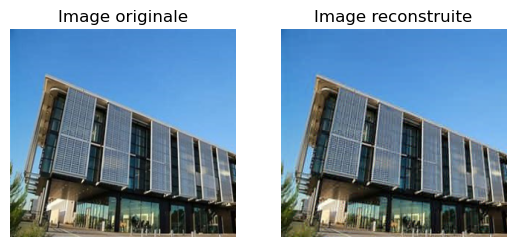

In [6]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Dec 18 13:18:50 2023

avec matrice Q de luminance 
"""
#importation des bibliothèques

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


#A/INITIALISATION


#lecture de l'image

M=mpimg.imread("C:/Users/radou/Desktop/New folder/Test2.png")

if M.shape[2] == 4:  # Vérifie si l'image a quatre canaux (avec canal alpha)
    M = M[:, :, :3]

#Transformation en matrice 2D

H=M[:,:,1]
K=M[:,:,2]
L=M[:,:,0]



#tronquer l'image

lignes, colonnes = L.shape

l= (lignes // 8) * 8   #tronque en multiple de 8
c = (colonnes // 8) * 8

M = M[:l, :c] #pour faire le taux d'erreur plus tard
L = L[:l, :c]
H = H[:l, :c]
K = K[:l, :c]

#Transformations des intensités

L=(L*255)-128  #rammene les valeurs entre -128 et 127
H=(H*255)-128
K=(K*255)-128




# Calcul de P

P = np.zeros((8, 8))
c0 = 1 / np.sqrt(2)

# Première ligne de P
P[0, :] = 0.5 * c0

# Calcul du reste de P
for i in range(1, 8):
    for j in range(8):
        P[i, j] = 0.5 * np.cos(((2 * j + 1) * i * np.pi) / 16)


#B/COMPRESSION

Q=np.array([
    [10, 15, 25, 37, 51, 66, 82, 100],
    [15, 19, 28, 39, 52, 67, 84, 101],
    [24, 28, 35, 45, 58, 73, 90, 107],
    [37, 39, 45, 51, 65, 80, 97, 114],
    [51, 52, 58, 65, 76, 91, 108, 125],
    [66, 67, 73, 80, 91, 105, 122, 139],
    [82, 84, 90, 97, 108, 122, 140, 157],
    [100, 101, 107, 114, 125, 139, 157, 175]])



#Compression

MC=np.zeros((l,c))
HC=np.zeros((l,c))
KC=np.zeros((l,c))

for i in range(l//8):
    for j in range(c//8):
        D = np.dot(np.dot(P,L[8*i:8*(1+i),8*j:8*(1+j)]),np.transpose(P))
        D = np.round(D / Q).astype(int)
        E = np.dot(np.dot(P,H[8*i:8*(1+i),8*j:8*(1+j)]),np.transpose(P))
        E = np.round(E / Q).astype(int)
        F = np.dot(np.dot(P,K[8*i:8*(1+i),8*j:8*(1+j)]),np.transpose(P))
        F = np.round(F / Q).astype(int)
        MC[8*i:8*(1+i),8*j:8*(1+j)] = np.clip(D, -128, 127)
        HC[8*i:8*(1+i),8*j:8*(1+j)] = np.clip(E, -128, 127)
        KC[8*i:8*(1+i),8*j:8*(1+j)] = np.clip(F, -128, 127)



MN=np.stack((MC,HC,KC), axis=-1)

#Taux de compression

s=np.sum(MN==0)
taux_compression=(s/(3*l*c))*100
print('le taux de compression est de l\'ordre de',taux_compression)




#Filtrage des haute fréquences et debruitage

f = int(input('Quel est la fréquence de coupure?'))




for i in range(l // 8):
    for j in range(c // 8):
        sous_matrice1 = MC[8*i:8*(i+1),8*j:8*(j+1)]  # Extraire la sous-matrice 8x8
        indices1 = np.indices(sous_matrice1.shape).sum(axis=0) 
        sous_matrice1[indices1 > f] = 0
        MC[8*i:8*(i+1), 8*j:8*(j+1)] = sous_matrice1
        sous_matrice2 = HC[8*i:8*(i+1),8*j:8*(j+1)]  # Extraire la sous-matrice 8x8
        indices2 = np.indices(sous_matrice2.shape).sum(axis=0) 
        sous_matrice2[indices2 > f] = 0
        HC[8*i:8*(i+1), 8*j:8*(j+1)] = sous_matrice2
        sous_matrice3 = KC[8*i:8*(i+1),8*j:8*(j+1)]  # Extraire la sous-matrice 8x8
        indices3 = np.indices(sous_matrice3.shape).sum(axis=0)
        sous_matrice3[indices3 > f] = 0
        KC[8*i:8*(i+1), 8*j:8*(j+1)] = sous_matrice3



#C/DECOMPRESSION



for i in range(l//8):
    for j in range(c//8):
        MC[8*i:8*(1+i),8*j:8*(1+j)] = np.round(MC[8*i:8*(1+i),8*j:8*(1+j)]*Q).astype(int)
        MC[8*i:8*(1+i),8*j:8*(1+j)] = np.dot(np.dot(np.transpose(P),MC[8*i:8*(1+i),8*j:8*(1+j)]),P)
        MC[8*i:8*(1+i),8*j:8*(1+j)] = np.clip(MC[8*i:8*(1+i),8*j:8*(1+j)], -128, 127)
        HC[8*i:8*(1+i),8*j:8*(1+j)] = np.round(HC[8*i:8*(1+i),8*j:8*(1+j)]*Q).astype(int)
        HC[8*i:8*(1+i),8*j:8*(1+j)] = np.dot(np.dot(np.transpose(P),HC[8*i:8*(1+i),8*j:8*(1+j)]),P)
        HC[8*i:8*(1+i),8*j:8*(1+j)] = np.clip(HC[8*i:8*(1+i),8*j:8*(1+j)], -128, 127)
        KC[8*i:8*(1+i),8*j:8*(1+j)] = np.round(KC[8*i:8*(1+i),8*j:8*(1+j)]*Q).astype(int)
        KC[8*i:8*(1+i),8*j:8*(1+j)] = np.dot(np.dot(np.transpose(P),KC[8*i:8*(1+i),8*j:8*(1+j)]),P)
        KC[8*i:8*(1+i),8*j:8*(1+j)] = np.clip(KC[8*i:8*(1+i),8*j:8*(1+j)], -128, 127)

MC=(MC+128)/255
HC=(HC+128)/255
KC=(KC+128)/255

MNf=np.stack((MC,HC,KC), axis=-1)


#Calcul du taux d'erreur


erreur_totale = np.linalg.norm(M - MNf) / np.linalg.norm(M)

print("Taux d'erreur total sur l'image en couleur :", erreur_totale)

#D/AFFICHER LA NOUVELLE IMAGE



plt.subplot(1, 2, 1)
plt.title('Image originale')
plt.imshow(M)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Image reconstruite')
plt.imshow(MNf)
plt.axis('off')
plt.show()

le taux de compression est de l'ordre de 88.296914160401


Quel est la fréquence de coupure? 6


Taux d'erreur total sur l'image en couleur : 0.0514415092811888


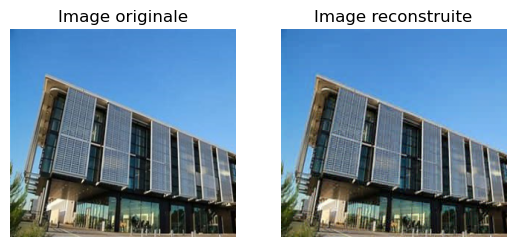

In [7]:
# -*- coding: utf-8 -*-
"""
Created on Mon Dec 18 13:18:50 2023

avec matrice Q de chrominance 
"""
#importation des bibliothèques

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


#A/INITIALISATION


#lecture de l'image

M=mpimg.imread("C:/Users/radou/Desktop/New folder/Test2.png")

if M.shape[2] == 4:  # Vérifie si l'image a quatre canaux (avec canal alpha)
    M = M[:, :, :3]

#Transformation en matrice 2D

H=M[:,:,1]
K=M[:,:,2]
L=M[:,:,0]



#tronquer l'image

lignes, colonnes = L.shape

l= (lignes // 8) * 8   #tronque en multiple de 8
c = (colonnes // 8) * 8

M = M[:l, :c] #pour faire le taux d'erreur plus tard
L = L[:l, :c]
H = H[:l, :c]
K = K[:l, :c]

#Transformations des intensités

L=(L*255)-128  #rammene les valeurs entre -128 et 127
H=(H*255)-128
K=(K*255)-128




# Calcul de P

P = np.zeros((8, 8))
c0 = 1 / np.sqrt(2)

# Première ligne de P
P[0, :] = 0.5 * c0

# Calcul du reste de P
for i in range(1, 8):
    for j in range(8):
        P[i, j] = 0.5 * np.cos(((2 * j + 1) * i * np.pi) / 16)


#B/COMPRESSION

Q=np.array([
    [20, 23, 26, 30, 35, 40, 46, 53],
    [23, 26, 30, 35, 40, 46, 53, 60],
    [26, 30, 35, 40, 46, 53, 60, 68],
    [30, 35, 40, 46, 53, 60, 68, 76],
    [35, 40, 46, 53, 60, 68, 76, 85],
    [40, 46, 53, 60, 68, 76, 85, 94],
    [46, 53, 60, 68, 76, 85, 94, 104],
    [53, 60, 68, 76, 85, 94, 104, 114]
])




#Compression

MC=np.zeros((l,c))
HC=np.zeros((l,c))
KC=np.zeros((l,c))

for i in range(l//8):
    for j in range(c//8):
        D = np.dot(np.dot(P,L[8*i:8*(1+i),8*j:8*(1+j)]),np.transpose(P))
        D = np.round(D / Q).astype(int)
        E = np.dot(np.dot(P,H[8*i:8*(1+i),8*j:8*(1+j)]),np.transpose(P))
        E = np.round(E / Q).astype(int)
        F = np.dot(np.dot(P,K[8*i:8*(1+i),8*j:8*(1+j)]),np.transpose(P))
        F = np.round(F / Q).astype(int)
        MC[8*i:8*(1+i),8*j:8*(1+j)] = np.clip(D, -128, 127)
        HC[8*i:8*(1+i),8*j:8*(1+j)] = np.clip(E, -128, 127)
        KC[8*i:8*(1+i),8*j:8*(1+j)] = np.clip(F, -128, 127)


MN=np.stack((MC,HC,KC), axis=-1)

#Taux de compression

s=np.sum(MN==0)
taux_compression=(s/(3*l*c))*100
print('le taux de compression est de l\'ordre de',taux_compression)





#Filtrage des haute fréquences et debruitage

f = int(input('Quel est la fréquence de coupure?'))




for i in range(l // 8):
    for j in range(c // 8):
        sous_matrice1 = MC[8*i:8*(i+1),8*j:8*(j+1)]  # Extraire la sous-matrice 8x8
        indices1 = np.indices(sous_matrice1.shape).sum(axis=0) 
        sous_matrice1[indices1 > f] = 0
        MC[8*i:8*(i+1), 8*j:8*(j+1)] = sous_matrice1
        sous_matrice2 = HC[8*i:8*(i+1),8*j:8*(j+1)]  # Extraire la sous-matrice 8x8
        indices2 = np.indices(sous_matrice2.shape).sum(axis=0) 
        sous_matrice2[indices2 > f] = 0
        HC[8*i:8*(i+1), 8*j:8*(j+1)] = sous_matrice2
        sous_matrice3 = KC[8*i:8*(i+1),8*j:8*(j+1)]  # Extraire la sous-matrice 8x8
        indices3 = np.indices(sous_matrice3.shape).sum(axis=0)
        sous_matrice3[indices3 > f] = 0
        KC[8*i:8*(i+1), 8*j:8*(j+1)] = sous_matrice3



#C/DECOMPRESSION



for i in range(l//8):
    for j in range(c//8):
        MC[8*i:8*(1+i),8*j:8*(1+j)] = np.round(MC[8*i:8*(1+i),8*j:8*(1+j)]*Q).astype(int)
        MC[8*i:8*(1+i),8*j:8*(1+j)] = np.dot(np.dot(np.transpose(P),MC[8*i:8*(1+i),8*j:8*(1+j)]),P)
        MC[8*i:8*(1+i),8*j:8*(1+j)] = np.clip(MC[8*i:8*(1+i),8*j:8*(1+j)], -128, 127)
        HC[8*i:8*(1+i),8*j:8*(1+j)] = np.round(HC[8*i:8*(1+i),8*j:8*(1+j)]*Q).astype(int)
        HC[8*i:8*(1+i),8*j:8*(1+j)] = np.dot(np.dot(np.transpose(P),HC[8*i:8*(1+i),8*j:8*(1+j)]),P)
        HC[8*i:8*(1+i),8*j:8*(1+j)] = np.clip(HC[8*i:8*(1+i),8*j:8*(1+j)], -128, 127)
        KC[8*i:8*(1+i),8*j:8*(1+j)] = np.round(KC[8*i:8*(1+i),8*j:8*(1+j)]*Q).astype(int)
        KC[8*i:8*(1+i),8*j:8*(1+j)] = np.dot(np.dot(np.transpose(P),KC[8*i:8*(1+i),8*j:8*(1+j)]),P)
        KC[8*i:8*(1+i),8*j:8*(1+j)] = np.clip(KC[8*i:8*(1+i),8*j:8*(1+j)], -128, 127)

MC=(MC+128)/255
HC=(HC+128)/255
KC=(KC+128)/255

MNf=np.stack((MC,HC,KC), axis=-1)

#Calcul du taux d'erreur



erreur_totale = np.linalg.norm(M - MNf) / np.linalg.norm(M)

print("Taux d'erreur total sur l'image en couleur :", erreur_totale)

#D/AFFICHER LA NOUVELLE IMAGE



plt.subplot(1, 2, 1)
plt.title('Image originale')
plt.imshow(M)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Image reconstruite')
plt.imshow(MNf)
plt.axis('off')
plt.show()

In [11]:
pip install scipy


Note: you may need to restart the kernel to use updated packages.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Taux d'erreur : 0.0776


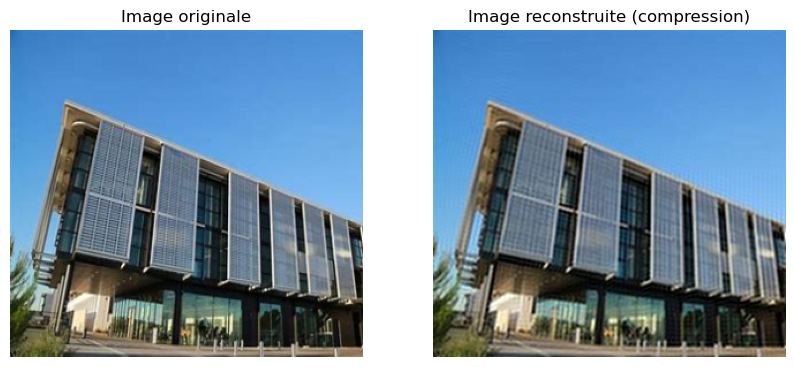

In [8]:
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
import numpy as np
"""
utilisation de la dct et de la idct de scipy 

"""

# Chemin de l'image à compresser
image_path = "C:/Users/radou/Desktop/New folder/Test2.png"

# Facteur de compression (0.5 signifie une réduction de moitié des coefficients)
compression_factor = 0.5

# Charger l'image
original_image = plt.imread(image_path)

# Vérifier si l'image est en couleurs (avec un canal alpha)
if original_image.shape[2] == 4:
    original_image = original_image[:, :, :3]

# Obtenir les dimensions de l'image
lignes, colonnes, _ = original_image.shape

# Transformer l'image en valeurs entre -128 et 127
image_transformée = (original_image * 255) - 128

# Appliquer la DCT à chaque canal de couleur
dct_image = dct(dct(image_transformée, axis=0, norm='ortho'), axis=1, norm='ortho')

# Appliquer la compression en mettant à zéro les coefficients
# de fréquence élevée en fonction du facteur de compression
compressed_dct_image = dct_image.copy()
compressed_dct_image[int(lignes * compression_factor):, :] = 0
compressed_dct_image[:, int(colonnes * compression_factor):] = 0

# Appliquer la IDCT pour décompresser l'image
decompressed_image = idct(idct(compressed_dct_image, axis=0, norm='ortho'), axis=1, norm='ortho')

# Ramener les valeurs entre 0 et 255
decompressed_image = (decompressed_image + 128) / 255

# Calculer le taux d'erreur
error_rate = np.linalg.norm(original_image - decompressed_image) / np.linalg.norm(original_image)

# Afficher les résultats
print("Taux d'erreur : {:.4f}".format(error_rate))

# Afficher les images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Image originale')
plt.imshow(original_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Image reconstruite (compression)')
plt.imshow(decompressed_image)
plt.axis('off')

plt.show()
